# TP Large Scale Kernel Methods

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


In [3]:
import gc
gc.collect()

32

## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [17]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
#timing_kernel = time() - t0
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t1))
accuracy_kernel = accuracy_score(y_pred, y_test)
# TODO
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)

# TODO same for LinearSVC

# timing_linear = 

Fitting SVC rbf on 20000 samples...
done in 8.243s
Predicting with SVC rbf on 40000 samples...
done in 9.940s
done in 9.950s
classification accuracy: 0.980


In [5]:
print("Fitting LinearSVC on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = LinearSVC(random_state=42, tol=1e-5, dual=False)
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t1 = time()
#timing_kernel = time() - t0
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t1))
accuracy_linear = accuracy_score(y_pred, y_test)
# TODO
print("done in %0.3fs" % (time() - t1))
timing_linear = time() - t0
print("classification accuracy: %0.3f" % accuracy_linear)

Fitting LinearSVC on 20000 samples...
done in 0.299s
Predicting with LinearSVC on 40000 samples...
done in 0.037s
done in 0.048s
classification accuracy: 0.917


### Comparaison des temps de calculs
- Pour l'apprentissage, on constate que le temps mis par la méthode SVM avec noyau gaussien est supérieur à la méthode linéaire **8.443s** contre **0.465s**. Nous avons presque **8 secondes de différence entre les 2 méthodes**


- En ce qui concerne la prédiction sur les données de Test, nous constatons que celle effectuée avec la méthode SVM à noyau gaussien nécessite plus de temps **(10.044s)** que celle linéaire **(0.041s)**. Nous avons plus de **10 secondes de différences**

### Comparaison des précisions
- Bien qu'elle soit plus longue en apprentissage et en prédiction, la méthode SVM à noyau gaussienn nous donne une meilleure précision **(0.980)** que celle linéaire **(0.917)**

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [6]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, s, vt = svds(gram_mat, k=k)
        gram_mat_k = np.dot(u, np.dot(np.diag(s),vt))
    else:
        u, s, vt = svd(gram_mat, full_matrices=False)
        gram_mat_k = np.dot(u[:,:k], np.dot(np.diag(s[:k]),vt[:k,:]))

    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [7]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    #print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = np.linalg.norm(gram_mat_k - gram_signal , 'fro')/np.linalg.norm(gram_signal , 'fro')

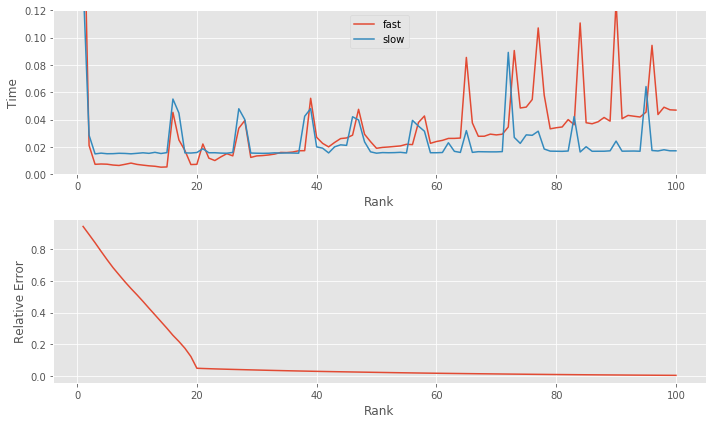

In [8]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylim([0.,0.12])
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

On constate qu'au-delà de **l'itération de rang 20**, **l'erreur relative varie très faiblement.**

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [9]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    w = np.random.normal(0,np.sqrt(2*gamma),(n_features,c))
    b = np.random.uniform(0,2*np.pi,(1,c))

    X_new_train = np.sqrt(2/c)*np.cos(np.dot(X_train,w) + b)
    X_new_test = np.sqrt(2/c)*np.cos(np.dot(X_test, w) + b)
    
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [10]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 2.792s
Predicting with SVC linear on 40000 samples...
done in 0.035s
classification accuracy: 0.960


### Comparaison des temps de calculs
- Pour l'apprentissage, on constate que le temps mis par la méthode Random features Kernel **2.438s** est inférieur au SVM avec noyau gaussien **8.443s** mais supérieur au SVM linéaire **0.465s**. 


- En ce qui concerne la prédiction sur les données de Test, nous constatons que celle effectuée avec cette nouvelle méthode **0.099s** est inférieur à la méthode SVM à noyau gaussien qui nécessite **(10.044s)** mais supérieur au SVM linéaire qui prend **(0.041s)**. 

### Comparaison des précisions
- La méthode **Random Features Kernel** nous donne une précision de **0.964**. Cette précision est inférieure à la méthode SVM à noyau gaussien **(0.980)** mais supérieure à la précision SVM linéaire **(0.917)**

## Question 6

On implémente la méthode de Nystrom.

In [11]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    u, s, vt = svd(W)
    # calcul de Wk
    w_k = np.dot(u[:,:k], np.dot(np.diag(s[:k]),vt[:k,:]))
    
    # Calcul de Mk
    m_k = np.dot(u[:,:k], np.diag(1/np.sqrt(s[:k])))
    
    # Calcul de Ctrain et Ctest
    idx = rng.choice(n_samples, c)
    c_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    
    c_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = np.dot(c_train, m_k)
    X_new_test = np.dot(c_test, m_k)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [12]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 2.354s
Predicting with SVC linear on 40000 samples...
done in 0.035s
classification accuracy: 0.976


## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [14]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    #print(i, c)
    #random_features
    #t0 = time()
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy = clf.score(Z_test, y_test)
    timing_rkf[i] = time() - t0
    accuracy_rkf[i] = accuracy
    
    #nystrom    
    #t0 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t0
    accuracy_nystrom[i] = accuracy


Training SVMs for various values of c...


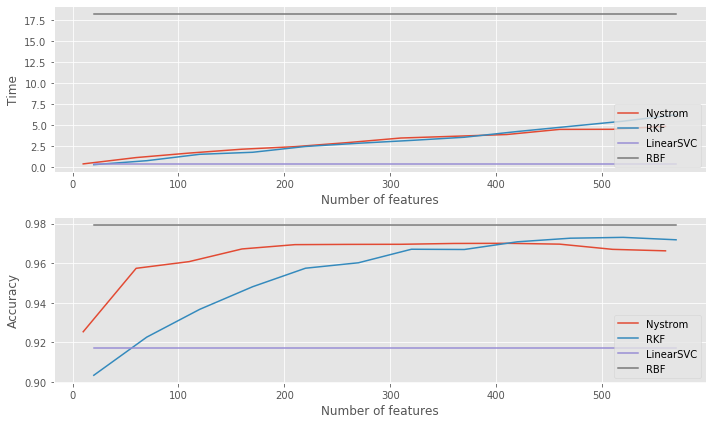

In [22]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Comparaison des temps de calculs
- Pour les méthodes **Nystrom** et **Random Kernel Features**, nous constatons que **le temps de calcul augmente** avec **le nombre de features**.

### Comparaison des précisions
- Globalement, nous constatons que pour les méthodes **Nystrom** et **Random Kernel Features**, la **précision** augmente avec le **nombre de features.**

### Question Bonus

In [18]:
from sklearn.metrics.pairwise import laplacian_kernel

def nystrom_laplace(X_train, X_test, gamma, c=500, k=200, seed=44):
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = laplacian_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    u, s, vt = svd(W)
    # calcul de Wk
    w_k = np.dot(u[:,:k], np.dot(np.diag(s[:k]),vt[:k,:]))
    
    # Calcul de Mk
    m_k = np.dot(u[:,:k], np.diag(1/np.sqrt(s[:k])))
    
    # Calcul de Ctrain et Ctest
    idx = rng.choice(n_samples, c)
    c_train = laplacian_kernel(X_train, X_train_idx, gamma=gamma)
    
    c_test = laplacian_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = np.dot(c_train, m_k)
    X_new_test = np.dot(c_test, m_k)

    return X_new_train, X_new_test

In [19]:
Z_train, Z_test = nystrom_laplace(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.895s
Predicting with SVC linear on 40000 samples...
done in 0.035s
classification accuracy: 0.972


In [20]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_nystrom_laplace = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_nystrom_laplace = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    #print(i, c)
    #random_features
    t0 = time()
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy = clf.score(Z_test, y_test)
    timing_rkf[i] = time() - t0
    accuracy_rkf[i] = accuracy
    
    #nystrom    
    t0 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t0
    accuracy_nystrom[i] = accuracy
    
    #nystrom    
    t0 = time()
    Z_train, Z_test = nystrom_laplace(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy = clf.score(Z_test, y_test)
    timing_nystrom_laplace[i] = time() - t0
    accuracy_nystrom_laplace[i] = accuracy

Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


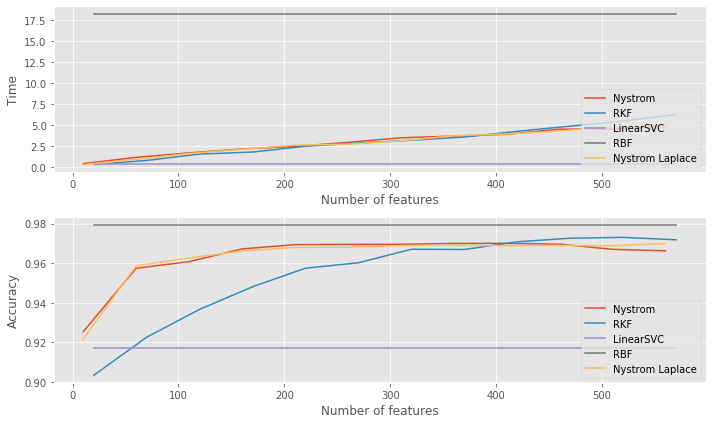

In [21]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')
ax1.plot(ranks-10, timing_nystrom_laplace, '-', label='Nystrom Laplace')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.plot(ranks-10, accuracy_nystrom_laplace, '-', label='Nystrom Laplace')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()